![banniere_one](img/banniere.png)

# Introduction

Nous allons voir 

In [1]:
# Import des dépendances python nécessaire 

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import joblib
import tempfile
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

import mlflow
from mlflow.models import infer_signature

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

# Créer un répertoire temporaire dans la racine du projet
temp_dir = os.path.join(os.getcwd(), 'temp_model_dir')
os.makedirs(temp_dir, exist_ok=True)

# MLflow tracking
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Pneumonia_Classification_DenseNet121")
mlflow.start_run()

2025-05-26 22:41:40.320164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 22:41:40.322936: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 22:41:40.330126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748292100.341460   25346 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748292100.344822   25346 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748292100.355003   25346 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

<ActiveRun: >

# Exploration des données 

Ici nous allons simplement affciher une radio pour vérifier qu'on arrive à la lire. 

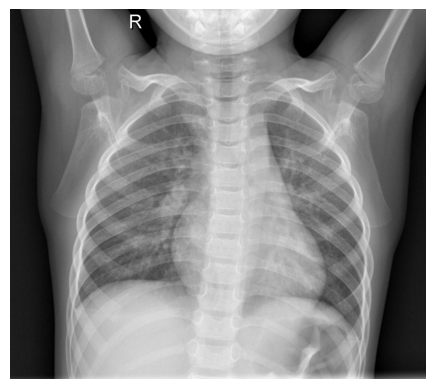

Shape (dimensions)    : (1858, 2090, 3)
Type des valeurs      : uint8


In [2]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/train/NORMAL/IM-0115-0001.jpeg", cv2.IMREAD_COLOR)

# Observer l'image sous forme de matrice
#print(img)

# Visualisation de l'image
plt.imshow(img)
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")


dans l'exemple ci-dessus nous avons effectivement une image affcihé donc on peut continuer. 

# Préparation des données 

Ici nous allons trasnformer nos images pour qu'elles soit conformer à la taille recommandé voulue par notre modèle et en format couleur.
nous allons ensuite les normaliser c'est à dire les convertir dans un format lisible pour notre modèle(ici: MobileNetV3Large)

In [3]:
def load_data(data_dir, img_read_type: int, target_size=(224, 224)):
    """
    Charge les images et les étiquettes depuis un répertoire structuré en sous-dossiers 'NORMAL' et 'PNEUMONIA'.

    Parameters
    ----------
    data_dir : str
        Chemin du dossier contenant deux sous-dossiers : 'NORMAL' et 'PNEUMONIA', chacun contenant les images correspondantes.
    img_read_type : int
        Mode de lecture des images pour OpenCV (par exemple cv2.IMREAD_GRAYSCALE ou cv2.IMREAD_COLOR).
    target_size : tuple (int, int), default=(224, 224)
        Dimensions finales souhaitées pour les images après redimensionnement.

    Returns
    -------
    X : 
        Tableau des images chargées et redimensionnées, converties en float32.
        La forme dépend du mode de lecture (grayscale ou couleur).
    
    y : 
        Tableau des labels (0 pour 'NORMAL', 1 pour 'PNEUMONIA').
    """

    X = []
    y = []
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1}

    for label_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(data_dir, label_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible, on passe
                img = cv2.resize(img, target_size)
                X.append(img)
                y.append(label_map[label_name])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

X_train, y_train = load_data("data/train", cv2.IMREAD_COLOR)
X_test, y_test = load_data("data/test", cv2.IMREAD_COLOR)
X_valid, y_valid= load_data("data/val", cv2.IMREAD_COLOR)

In [4]:
# Créer un générateur d'images avec normalisation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Créer des générateurs à partir des tableaux NumPy
train_generator = datagen.flow(X_train, y_train, batch_size=32)
valid_generator = datagen.flow(X_valid, y_valid, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32,shuffle=False)

In [5]:
# Définir la fonction pour calculer les class_weights
def compute_class_weights(y):
    """
    Calcule les poids de classe pour un ensemble d'étiquettes.

    Parameters
    ----------
    y : array-like
        Tableau des étiquettes de classe.

    Returns
    -------
    dict
        Dictionnaire des poids de classe.
    """
    # Calculer les poids de classe
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    
    # Créer un dictionnaire de poids
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    return class_weight_dict

# Calculer les class_weights
class_weights = compute_class_weights(y_train)

une fois les images préparé on vérfie que nous pouvons lire les images, on va prendre un échantillon de 10 images 

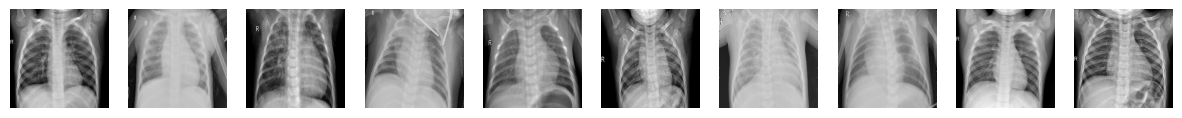

In [6]:
# Test images aléatoires

# Supposons que X_train est votre ensemble de données d'images
# Nombre d'images à afficher
num_images = 10

# Sélectionner des indices aléatoires
random_indices = np.random.choice(len(X_train), num_images, replace=False)

# Vérification des données préparées
plt.figure(figsize=(15, 5))  # Ajustez la taille de la figure si nécessaire
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    
    # Normaliser l'image pour l'affichage
    img = X_train[idx] / 255.0  # Normalisation pour afficher entre 0 et 1
    plt.imshow(img)
    plt.axis("off")

plt.show()

les images sont corects, on continue 

# Création modele 

In [7]:
base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
features = base_model.output
features = GlobalAveragePooling2D()(features)
features = Dropout(0.3)(features)
output = Dense(1, activation='sigmoid')(features)

model = Model(inputs=base_model.input, outputs=output)

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

2025-05-26 22:42:11.093659: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping pour éviter l'overfitting
early_stop = EarlyStopping(patience=4, restore_best_weights=True)

# Enregistrer les paramètres
mlflow.log_param("model", "MobileNetV3Large")
mlflow.log_param("epochs", 10)
mlflow.log_param("batch_size", 32)
mlflow.log_param("learning_rate", 0.001)  # Si vous utilisez un learning rate spécifique

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_valid) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# Évaluation modele avant fine_tuning 
loss, acc = model.evaluate(test_generator, steps=len(X_test) // 32)
mlflow.log_metric("test_loss", loss)
mlflow.log_metric("test_accuracy", acc)
print(f"Test accuracy: {acc*100:.2f}%")
print(f"Pertes : {loss}")


/home/drawile/Dev/projet_python_ia_v1/MlFlow_medical_screen_CNN/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 340ms/step - accuracy: 0.7677 - loss: 0.5114 - val_accuracy: 0.6875 - val_loss: 0.6918
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 338ms/step - accuracy: 0.8854 - loss: 0.2649 - val_accuracy: 0.7500 - val_loss: 0.4359
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.9144 - loss: 0.2082 - val_accuracy: 0.8125 - val_loss: 0.3718
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.9144 - loss: 0.2064 - val_accuracy: 0.8125 - val_loss: 0.3953
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 341ms/step - accuracy: 0.9287 - loss: 0.1676 - val_accuracy: 0.8750 - val_loss: 0.2794
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 339ms/step - accuracy: 0.9212 - loss: 0.1805 - val_accuracy: 0.9375 - val_loss: 0.1649
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.9384 - loss: 0.1457 - val_accuracy: 0.9375 - val_loss: 0.3270
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 338ms/step - accuracy: 0.9337 - loss: 0

On vérifie avec ce graphique 

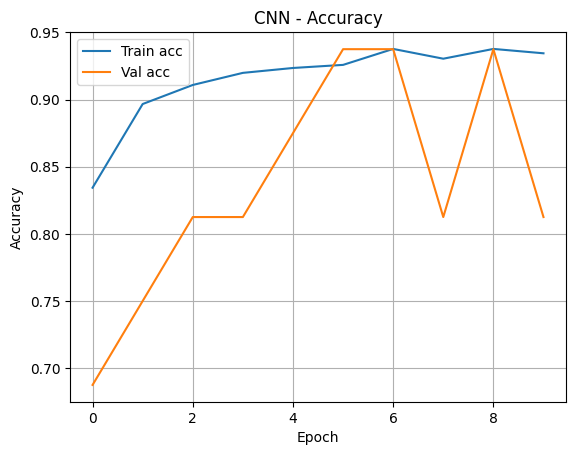

In [9]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("CNN - Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Ici nous allons "degeler" notre modele, ce principe permet à notre modele d'être plus performant et précis, nous allons dans ce cas-ci "dégeler" les 30 dernières couches 

In [10]:
# Défreezer les 30 dernières couches du modèle 
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompiler avec un learning rate plus petit
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
# Nouveau early stopping
early_stop_fine = EarlyStopping(patience=3, restore_best_weights=True)

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_valid) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop_fine]
)

# Évaluation
fine_tuned_loss, fine_tuned_acc = model.evaluate(test_generator, steps=len(X_test) // 32)
mlflow.log_metric("fine_tuned_accuracy", fine_tuned_acc)
mlflow.log_metric("fine_tuned_loss", fine_tuned_loss)
print(f"Test accuracy: {fine_tuned_acc*100:.2f}%")
print(f"Pertes : {loss}")


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 370ms/step - accuracy: 0.9273 - loss: 0.1924 - val_accuracy: 0.5625 - val_loss: 4.1441
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 363ms/step - accuracy: 0.9641 - loss: 0.0857 - val_accuracy: 0.6875 - val_loss: 2.8515
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.9639 - loss: 0.0883 - val_accuracy: 0.6875 - val_loss: 1.7784
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 363ms/step - accuracy: 0.9738 - loss: 0.0697 - val_accuracy: 0.9375 - val_loss: 0.1623
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 365ms/step - accuracy: 0.9708 - loss: 0.0689 - val_accuracy: 0.8750 - val_loss: 0.3013
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.9742 - loss: 0.0636 - val_accuracy: 0.9375 - val_loss: 0.2057
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 364ms/step - accuracy: 0.9811 - loss: 0.0462 - val_accuracy: 0.8750 - val_loss: 0.4176
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.5002 - loss: 7.2719
Test acc

Shape of images from test_generator: (32, 224, 224, 3)
Shape of labels from test_generator: (32,)
Sample images and labels:


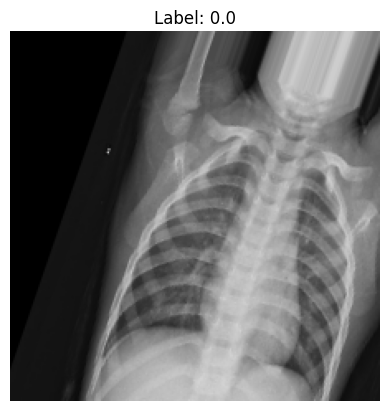

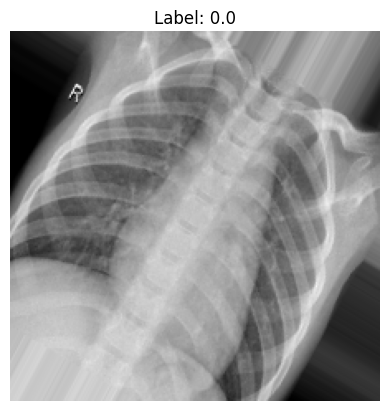

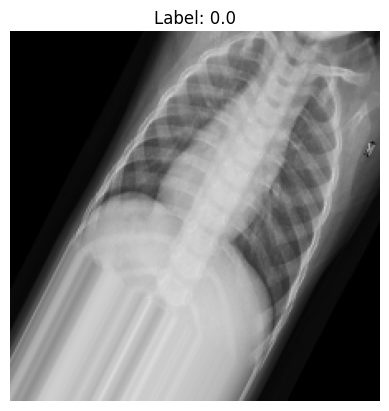

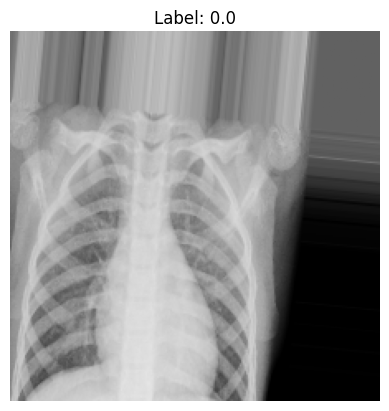

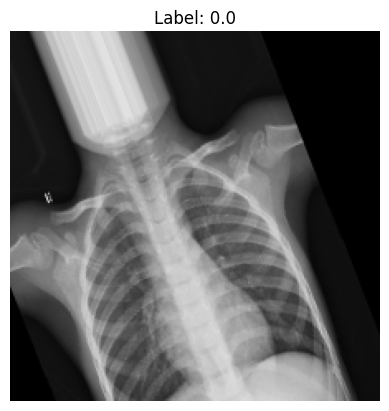

In [21]:
# Obtenir un lot d'images et d'étiquettes
images, labels = next(iter(test_generator))

# Afficher les dimensions
print(f"Shape of images from test_generator: {images.shape}")
print(f"Shape of labels from test_generator: {labels.shape}")

# Afficher quelques valeurs d'images et d'étiquettes
print("Sample images and labels:")
for i in range(5):  # Afficher les 5 premières images et étiquettes
    plt.imshow(images[i]/255.0)
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
    plt.show()

Vérification avec le fine-tune nous observons que 

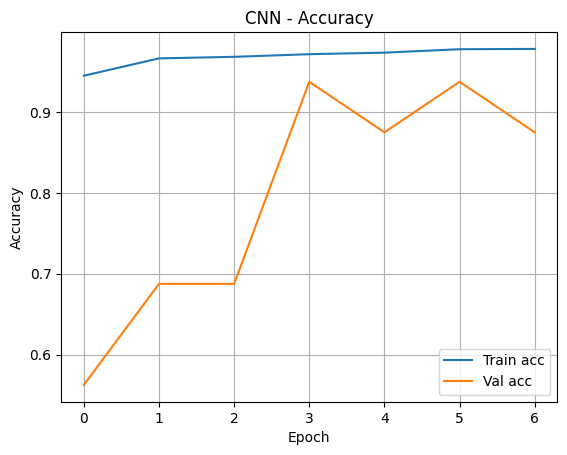

In [13]:
plt.plot(history_finetune.history['accuracy'], label='Train acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("CNN - Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Graphique et Enregistrement MlFlow 

Ici nous allons faire des tests avec différents graphiques pour tester notre modele et vérifier sa précision, le paramétre le plus important ici est le recall, plus un recall est proche de 1 plus le modéle est précis, nous vérifions également d'autres graphiques 


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step
Matrice de confusion :
[[ 78 156]
 [  0 390]]
Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       1.00      0.33      0.50       234
   PNEUMONIA       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.86      0.67      0.67       624
weighted avg       0.82      0.75      0.71       624



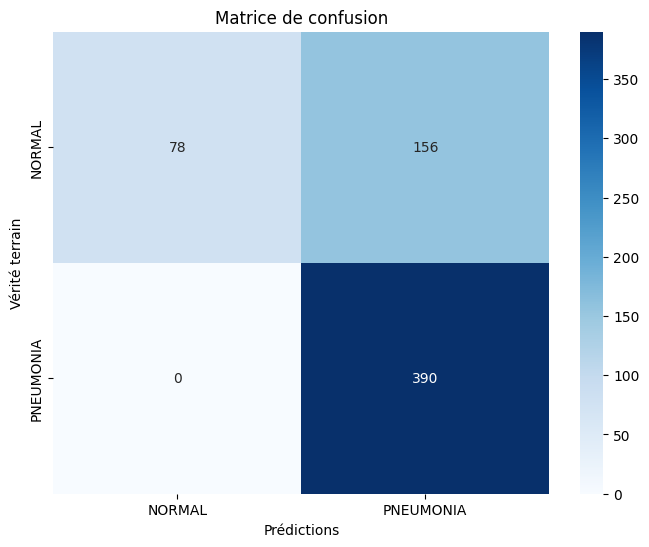

In [14]:
# Prédictions probabilistes (sorties sigmoid)
y_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = (y_probs > 0.5).astype("int32") 

# Obtenir les classes réelles à partir du générateur
y_test = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)

# Calculer le rapport de classification
class_report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print("Rapport de classification :")
print(class_report)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.ylabel('Vérité terrain')
plt.xlabel('Prédictions')
plt.title('Matrice de confusion')
plt.savefig("graph/confuse_matrix.png")
mlflow.log_artifact("graph/confuse_matrix.png")
plt.show()

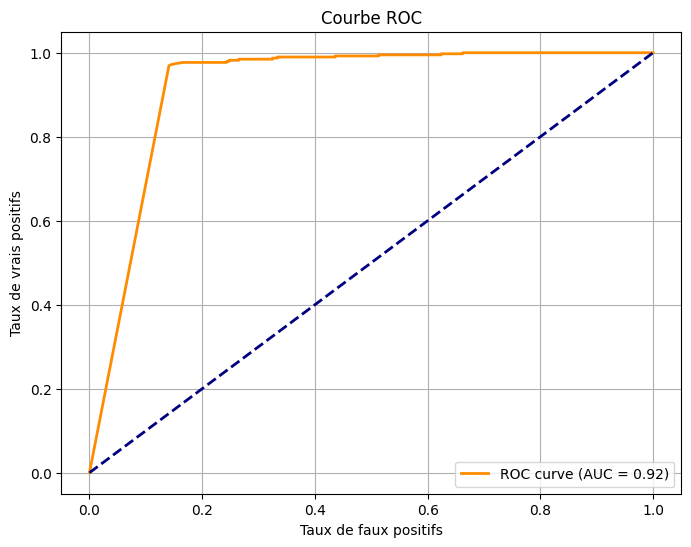

              precision    recall  f1-score   support

      Normal       1.00      0.33      0.50       234
   Pneumonia       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.86      0.67      0.67       624
weighted avg       0.82      0.75      0.71       624



<Figure size 640x480 with 0 Axes>

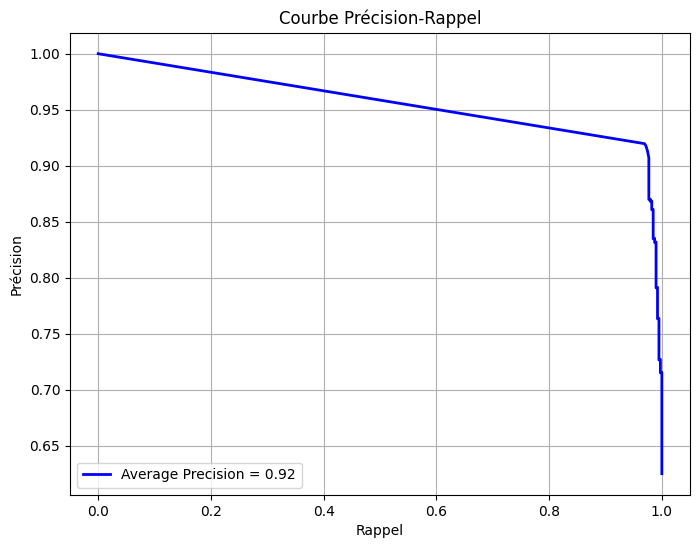

In [15]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
plt.savefig("graph/roc_curve.png")
mlflow.log_artifact("graph/roc_curve.png")

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f"Average Precision = {avg_precision:.2f}")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig("graph/precision_recall_curve.png")
mlflow.log_artifact("graph/precision_recall_curve.png")

# Rapport de classification
report = classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia'], output_dict=False)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


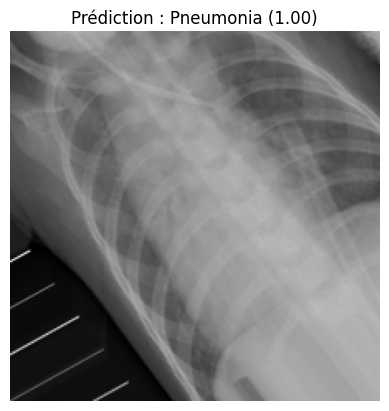

In [25]:
# Obtenir un lot d'images et d'étiquettes depuis test_generator
images, labels = next(iter(test_generator))

# Mapping des classes
label_name = {0: "Normal", 1: "Pneumonia"}

# Choisir un indice aléatoire dans le batch
i = random.randint(0, len(images) - 1)

# Prédiction
proba = model.predict(np.expand_dims(images[i], axis=0))[0][0]
predicted_class = int(proba > 0.5)

# Affichage de l’image
plt.imshow((images[i] / 255.0).astype(np.float32))  # /255 pour rendre l’image lisible
plt.title(f"Prédiction : {label_name[predicted_class]} ({proba:.2f})")
plt.axis("off")
plt.show()


# Test Mlflow

In [ ]:
# On récupère une batch d'exemple depuis test_generator
example_batch, _ = next(iter(test_generator))  # images, labels

# Prédictions sur cette batch
example_probs = model.predict(example_batch)

# Définir la signature à partir des données du vrai générateur
signature = infer_signature(example_batch, example_probs)

# Log du modèle avec input_example et signature corrects
mlflow.keras.log_model(model, "model", signature=signature, input_example=example_batch[:1])


mlflow.end_run()

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpt569s2tl/model/input_example.json'